In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import DataLoader
from plots.gifs import trajectory_gif
from plots.plots import get_feature_history, plt_train_error, plt_norm_state, plt_norm_control, plt_classifier, feature_plot, plt_dataset
from models.training import Trainer, robTrainer
from models.neural_odes import NeuralODE, robNeuralODE
from models.resnets import ResNet
import pickle
import sys
import matplotlib.pyplot as plt
import imageio

#if trainin false, models will be loaded from file
training = True

In [9]:
hidden_dim, data_dim = 2, 2
T, num_steps = 5.0, 10  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = True
bound = 0.
fp = False
cross_entropy = True



num_epochs = 90 #number of optimization epochs for gradient decent

if turnpike:
    weight_decay = 0 if bound>0. else dt*0.01
else: 
    weight_decay = dt*0.01          #0.01 for fp, 0.1 else

In [10]:
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity='tanh', 
                    architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)


anode_test = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity='tanh', 
                    architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode_test = torch.optim.Adam(anode_test.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_anode_test = Trainer(anode_test, optimizer_anode_test, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)


In [11]:

rob_node = robNeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity='tanh', 
                            architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)


optimizer_rob_node = torch.optim.Adam(rob_node.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_rob_node = robTrainer(rob_node, optimizer_rob_node, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)



                    

initializing self.adjoint_flow creates additional layers into rob_node. Does this effect the learning? Or can I just save/load only the important ones and it will be fine?

In [12]:
#%%capture #this surpresses output

with open('data.txt', 'rb') as fp:
    data_line, test = pickle.load(fp)
dataloader = DataLoader(data_line, batch_size=64, shuffle=True)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=True)


if training:
    trainer_anode.train(dataloader, num_epochs)
    trainer_anode_test.train(dataloader, num_epochs)

    #trainer_rob_node.train(dataloader, num_epochs)

    # torch.save(anode.state_dict(), 'anode.pth')
    # torch.save(rob_node.state_dict(), 'rob_node.pth')
# else:
    # anode.load_state_dict(torch.load('anode.pth'))
    # rob_node.load_state_dict(torch.load('rob_node.pth'))

/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/models/training.py:114: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)


tensor([12.8511,  4.7467])


/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/plots/plots.py:380: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = m(pre_)


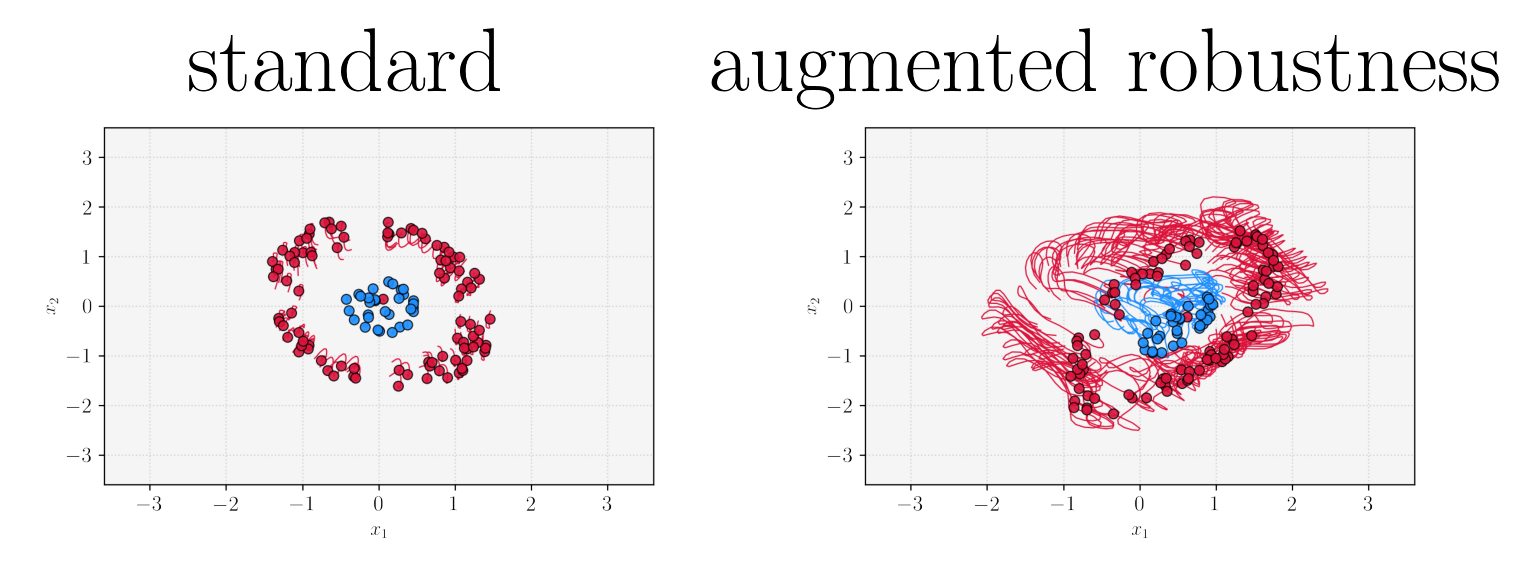

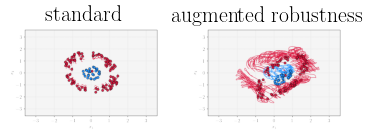

In [7]:
inputs, targets = next(iter(dataloader_viz))
print(sum(inputs))

inputs[0] = inputs[0] + 1

filename_base = '1traj'
filename_s = filename_base + '_s'
filename_r = filename_base + '_r'

plt_classifier(anode, num_steps=10, save_fig = '1generalization.pdf') 
plt_classifier(anode, num_steps=10, save_fig = '1rob_generalization.pdf') 

# plt_classifier(rob_node, num_steps=10, save_fig = '1rob_generalization.pdf')
trajectory_gif(anode, inputs, targets, timesteps=num_steps, filename = filename_s +'.gif')
trajectory_gif(anode_test, inputs, targets, timesteps=num_steps, filename = filename_r + '.gif')

plt.figure(1)
plt.subplot(121)
plt.imshow(imageio.imread(filename_s + '29.png'))
plt.title('standard')
plt.axis('off')
plt.subplot(122)
plt.imshow(imageio.imread(filename_r + '29.png'))
plt.title('augmented robustness')
plt.axis('off')

plt.savefig('1comparison_' + filename_base + '.png',
                    format='png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='1comparison_1traj.png') 

ValueError: Cannot embed the 'pdf' image format